In [1]:
# SET UP (it will take a long time to run)
using Pkg; Pkg.activate("C:/Users/nicot/GitHub/Tutorial_DynMacro")
using Plots; using Optim; using Interpolations; using LinearAlgebra;
Pkg.status()

  Activating environment at `C:\Users\nicot\GitHub\Tutorial_DynMacro\Project.toml`


      Status `D:\GitHub\Tutorial_DynMacro\Project.toml`
  [31c24e10] Distributions v0.23.11
  [2774e3e8] NLsolve v4.5.1
  [429524aa] Optim v1.4.1
  [fcd29c91] QuantEcon v0.16.2


# ESCRIBO


# The Ramsey Growth Model. A first VFI approach

About this model Keynes (1930) wrote "*... one of the most remarkable contributions to mathematical economics ever made, both in respect of the intrinsic importance and difficulty of its subject, the power and elegance of the technical methods employed, and the clear purity of illumination with which the writer’s mind is felt by the reader to play about its subject.*

Later formulations by Cass (1965) and by Koopmans (1965) were key to stablished this model as a cannonical model of macroeconomic theory. That's why it is also known as Ramsey-Cass-Koompans.

This notebook relies heavly in the following bibliography:
- Dynamic Economic. By Adda & Cooper
- Dynamic General Equilibrium Modelling. By Heer & Mauβner
- Quantitative Economics with Julia. By Perla, Sargent & Stachurski

## A deterministic farmer

For esposition convinience I start by simplifying the model. Instead of Ramsey's planner, and following Heer & Mauβner, I will think the *story* behind the model as the problem of Julia the farmer. She has already planted $K_0$ corn seeds, and she expects $f(K_0)$ of corn at $t=1$. Each period she must decide how to use the harvested corn, for consumption or for plantation $f(K_{t-1})=K_t+c_t$. In addtition to the profuction function $f$, there is a *time additive separable* utility function $U(\{c\}_{t=1}^\infty)=\sum_{t=1}^\infty \beta^{t-1} u(c_t)$, that represent Julia's preferences. (This problem implies full depreciation).


It is usually assumed:

1. $f(0)=0$ No free lunch
2. $f$ is twice continuosly differentiable
3. $f'(K)>0\quad\forall K$ Strictly increasing
4. $f''(K)\leq0$ Concave
5. $u$ is twice continuosly differentiable
6. $u'(c)>0\quad\forall c$ Strictly increasing
7. $u''(c)<0\quad\forall c$ Strictly concave
8. $c_t \geq 0\quad\forall t$
8. $K_t \geq 0\quad\forall t>0$
9. $K_0$ given
10. $U_t < \infty$ Transversality condition


Assumption 10 will hold if $u$ growth at a rate less than $1/\beta$. There is no need to assume that $u$ is bounded, since capital accumulation is. To see this, imagine that Julia eats 0 every single preiod. How would be capital accumulation? It will follow $K_t=f(K_{t-1})$, with an stable fixed point at $\bar{K}$. Therefor $K^{max}=max\{K_0;\bar{K}\}$.

Bellman's equation is

$$
V(K) = \max_{0 \leq c \leq f(K)}
    \left\{
        u(c) + \beta \; V(f(K)-c)
    \right\}
$$

We can also formulate Bellman's equation as:

$$
V(K) = \max_{0 \leq K' \leq f(K)}
    \left\{
        u(f(K)-K') + \beta \; V(K')
    \right\}
$$

The second equation is better for computational purposes, since we have to defined only $K$ grid. The first equation requires a grid for $K$ and another one for $c$.

#### First guess

From our knowledge of the model we know there is a stationary equilibrium at $K_{ss}$. Evaluating Bellman's equation at that point give us:

$$
V(K_{ss}) = u(f(K_{ss}-K_{ss}) + \beta \; V(K_{ss})
$$

Therefore,

$$
V(K_{ss}) = u(f(K_{ss}-K_{ss}) \; \frac{1}{1-\beta}
$$

The optimum value of $K_{ss}$ is the one that gives, the maximum consumption, this is know as the *golden rule*. However we know that it is not an steady state. This formulation suggest a good initial condition for VFI $V_1(K)= \frac{u(f(K)-K)}{1-\beta}$.

#### Choosing a functional form

For u and $f$ I am going to use the typical CRRA whith parameter $\gamma$ and a Cobb-Doulgas with parameter $\alpha$ and TFP $A$.

#### Choosing the grid

Since we know from theory that capital accumulation will evolve monotonically from $K_0$ to $K^*$ we can shorten the limits of the grid. If $K_0<K^*$ a good grid should be a discrtization of the interval $[K_0;K^*]$. If $K_0>K^*$ a good grid should be a discrtization of the interval $[K^*;K_0]$.

The number $n$ of grid points it is not a problem in the one-dimensional problem, but there could be a binding contrain of computational time in higher dimensional problems. For now, it is enough to know that the greater $n$, the finer the grid, and the better the aproximation.

So we can use the steady state value of $K^*=(\alpha \beta A)^{1/(1-\alpha)}$.

Another less convinient oprtion would be to use the golden rule. So $K_0$ or $K_g=(\alpha A)^{1/(1-\alpha)}$ would be the upper limit, and the grid would start at $0$

And a lesser convinient option would be the maximum possible value of $K$ that was previously mentioned. That is the stationary value associated with $c_t=0\;\forall t$. $K_{max}= A ^{1/(1-\alpha)}$.

In [10]:
γ = 1.0
A = 10.0
α = 0.5 
u(c) = γ==1.0 ?  log(c)  :  c^(1-γ)/(1-γ)   # CRRA
f(k)=A*k^α  # Cobb-Douglas

@show K_0 = 80 # initial condition
β = 0.9

V_0(k) = k #u(f(k)-k)/(1-β)

@show Kmax = A^(1/(1-α))  # what if c_t=0 for all t? f(K_max)=K_max. This could've been done with function fixedpoint of NSolve 
@show Kg = Optim.maximizer( maximize(V_0, 1e-5, max(K_0,Kmax)) ) # This could've been done analytically Kg=(A*α)^(1/(1-α))
@show Kss = (β*A*α)^(1/(1-α))

n=500 # grid points
which_k = 3 # 1: Kss   2: Kg   3: Kmax     # choose one of the above

if which_k==1
    K_grid =    Kss>=K_0 ?    range(K_0, Kss, length=n)  :  range(Kss, K_0, length=n)
elseif which_k==2
    K_grid = range(1e-10, max(K_0,Kg), length=n)
else
    K_grid = range(1e-10, max(K_0,Kmax), length=n)
end


K_0 = 80 = 80
Kmax = A ^ (1 / (1 - α)) = 100.0
Kg = Optim.maximizer(maximize(V_0, 1.0e-5, max(K_0, Kmax))) = 99.99999849478449
Kss = (β * A * α) ^ (1 / (1 - α)) = 20.25


1.0e-10:0.20040080160300602:100.0

In [11]:
function T(V, K_grid)
    V_fun = LinearInterpolation(K_grid, V, extrapolation_bc = Line()) # linear interpolation of the vectorized (or not) function

    objectives = (K -> u.((f(k)-K)) + β * V_fun(K)  for k in K_grid)
    
    K_min=K_grid[1]
    results = maximize.(objectives, K_min,f.(K_grid)) 

    V_new = Optim.maximum.(results)
    g_new = Optim.maximizer.(results)

    return V_new, g_new
end


T (generic function with 1 method)

Number of iterations: 50
Distance between last two value functions: 0.6445137499730162


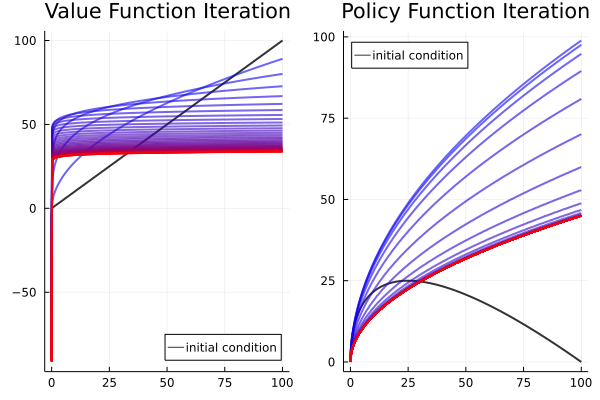

In [14]:
V=V_0.(K_grid) # dicretized form of V_0
g=f.(K_grid)-(K_grid) # initial polcy function consisten with V_0

pltV=plot(K_grid, V, color = :black, linewidth = 2, alpha = 0.8, label = "initial condition")
pltg=plot(K_grid, g, color = :black, linewidth = 2, alpha = 0.8, label = "initial condition")

max_iter = 50   
tol = 1e-10 # tolerance, if distance is below that I'm fine
distance=tol+1 # some initial condition for distance
i=1
while i < max_iter && distance > tol
    global V_new, g_new = T(V, K_grid)
    plot!(pltV,K_grid, V_new, color = RGBA(i/max_iter, 0, 1 - i/max_iter, 0.8), linewidth = 2, alpha = 0.6, label = "")
    plot!(pltg,K_grid, g_new, color = RGBA(i/max_iter, 0, 1 - i/max_iter, 0.8), linewidth = 2, alpha = 0.6, label = "")
    distance = norm(V_new - V)
    i += 1
    xx=5
    V = V_new  # copy contents into v.  Also could have used v[:] = v_next
end
g=LinearInterpolation(K_grid, g_new, extrapolation_bc = Line()) # policy function K_t => K_t+1

println("Number of iterations: ",i,"\nDistance between last two value functions: ",distance)

plot!(pltV, legend = :bottomright, title="Value Function Iteration")
plot!(pltg, legend = :topleft, title="Policy Function Iteration")
plot(pltV, pltg)

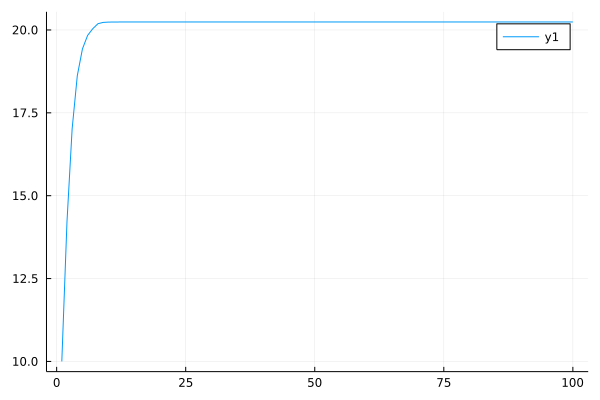

In [9]:
K_ini=10.0
Time=1:50
K_path=zeros(100)
K_path[1]=K_ini
for t in 2:100
    K_path[t]=g(K_path[t-1])
end
plot(K_path)

## Adding depreciation

To this introductory example we can easly add depreciation to this example. Let's suppose Julia has now a plantation of apples, $K_t$ accounts for the apple trees that she has at period $t$. She can turn the produced apples into a new apple trees. However a fixed prportion $\delta$ of trees die every period. Simple put, the net production function is $Y_t=f(K_{t-1})+(1-\delta)K_{t-1}$. Julia's restriction is as $Y_t=C_t+I_t$, and the law of motion of the trees is $K_t=I_{t-1}+(1-\delta)K_{t-1}$. Combining those equations we have $K_t=f(K_{t-1})-C_{t-1}+(1-\delta)K_{t-1}$

Bellman's equation is
$$
V(K) = \max_{0 \leq K' \leq f(K)}
    \left\{
        u(f(K)-K') + \beta \; V(K')
    \right\}
$$

You can verify that now $K_g=(\frac{Aα}{𝛿})^{1/(1-α)}$, $K_{max}=(\frac{A}{𝛿})^{1/(1-α)}$ and  $K^*=(\frac{\alpha \beta A}{1-\beta(1-\delta)})^{1/(1-\alpha)}$.

In [7]:
γ = 1.0
A = 10.0
α = 0.5 
𝛿 = 5/6
u(c) = γ==1.0 ?  log(c)  :  c^(1-γ)/(1-γ)   # CRRA
f(k)=A*k^α+(1-𝛿)*k # Cobb-Douglas with depretiation

@show K_0 = 80 # initial condition
β = 0.9

V_0(k) = u(f(k)-k)/(1-β)

@show Kmax = (A/𝛿)^(1/(1-α))  # what if c_t=0 for all t? f(K_max)=K_max. This could've been done with function fixedpoint of NSolve 
@show Kg = Optim.maximizer( maximize(V_0, 1e-5, max(K_0,Kmax)) ) # This could've been done analytically Kg=(A*α/𝛿)^(1/(1-α))
@show Kss = ((β*A*α)/(1-β*(1-𝛿)))^(1/(1-α))

n=500 # grid points
which_k = 3 # 1: Kss   2: Kg   3: Kmax     # choose one of the above

if which_k==1
    K_grid =    Kss>=K_0 ?    range(K_0, Kss, length=n)  :  range(Kss, K_0, length=n)
elseif which_k==2
    K_grid = range(1e-10, max(K_0,Kg), length=n)
else
    K_grid = range(1e-10, max(K_0,Kmax), length=n)
end


K_0 = 80 = 80
Kmax = (A / 𝛿) ^ (1 / (1 - α)) = 144.0
Kg = Optim.maximizer(maximize(V_0, 1.0e-5, max(K_0, Kmax))) = 36.00000001783523
Kss = ((β * A * α) / (1 - β * (1 - 𝛿))) ^ (1 / (1 - α)) = 28.027681660899653


1.0e-10:0.28857715430841685:144.0

In [8]:
function T(V, K_grid)
    V_fun = LinearInterpolation(K_grid, V, extrapolation_bc = Line()) # linear interpolation of the vectorized (or not) function

    objectives = (K -> u.((f(k)-K)) + β * V_fun(K)  for k in K_grid)
    
    K_min=K_grid[1]
    results = maximize.(objectives, K_min,f.(K_grid)) 

    V_new = Optim.maximum.(results)
    g_new = Optim.maximizer.(results)

    return V_new, g_new
end

T (generic function with 1 method)

Number of iterations: 28
Distance between last two value functions: 6.306325061869841e-11


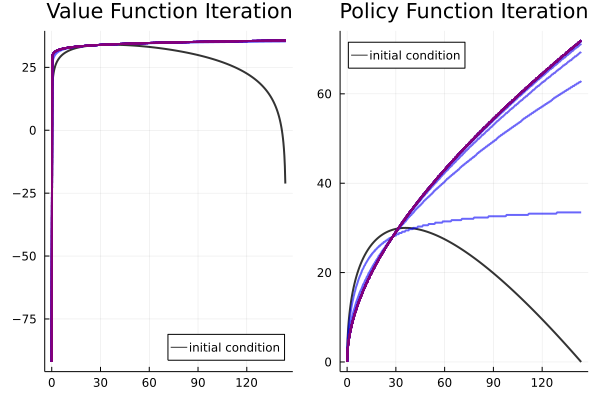

In [9]:
V=V_0.(K_grid) # dicretized form of V_0
g=f.(K_grid)-(K_grid) # initial polcy function consisten with V_0

pltV=plot(K_grid, V, color = :black, linewidth = 2, alpha = 0.8, label = "initial condition")
pltg=plot(K_grid, g, color = :black, linewidth = 2, alpha = 0.8, label = "initial condition")

max_iter = 50   
tol = 1e-10 # tolerance, if distance is below that I'm fine
distance=tol+1 # some initial condition for distance
i=1
while i < max_iter && distance > tol
    global V_new, g_new = T(V, K_grid)
    plot!(pltV,K_grid, V_new, color = RGBA(i/max_iter, 0, 1 - i/max_iter, 0.8), linewidth = 2, alpha = 0.6, label = "")
    plot!(pltg,K_grid, g_new, color = RGBA(i/max_iter, 0, 1 - i/max_iter, 0.8), linewidth = 2, alpha = 0.6, label = "")
    distance = norm(V_new - V)
    i += 1
    V = V_new  # copy contents into v.  Also could have used v[:] = v_next
end
g=LinearInterpolation(K_grid, g_new, extrapolation_bc = Line()) # policy function K_t => K_t+1

println("Number of iterations: ",i,"\nDistance between last two value functions: ",distance)

plot!(pltV, legend = :bottomright, title="Value Function Iteration")
plot!(pltg, legend = :topleft, title="Policy Function Iteration")
plot(pltV, pltg)

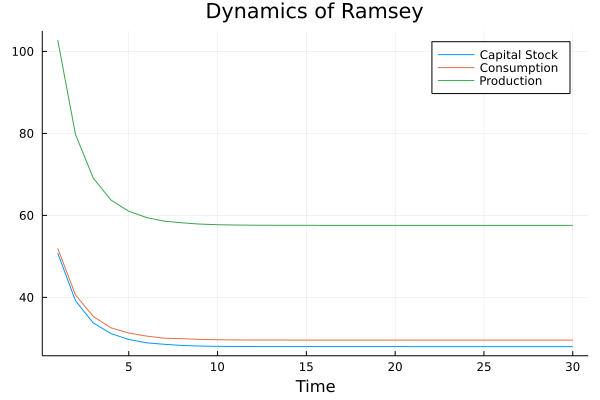

In [10]:
Time=30

y_path = ones(Time)
c_path = ones(Time)
K_path = ones(Time)
y_path[1] = f(K_0)
K_path[1] = g(K_0)
c_path[1] = y_path[1] - K_path[1]
for t in 2:(Time)  
    K_path[t] = g( K_path[t-1] )
    y_path[t] = f(K_path[t-1])
    c_path[t] = y_path[t] - K_path[t]
end

plot(1:Time,K_path,label="Capital Stock",title="Dynamics of Ramsey",xlabel="Time")
plot!(1:Time,c_path,label="Consumption")
plot!(1:Time,y_path,label="Production")

In [11]:
@show Kss
@show K_path[Time];

Kss = 28.027681660899653
K_path[Time] = 27.991983865901865


## Descentralized equilibrium

Now the *story* changes singnificanlly. There is an economy populated by a continuum of individuals of mass 1, and Julia one of the individuals can be thought as the representative agent of that economy. Similarly there is continum of firms of mass 1. Those firms have the same technology $f(k_t,n_t)$ and compite between each other. Therefore prices are determined competitively. However, will be easier to say "the firm" as is there was only one firm.

Julia borrows her capital $k_t$ to firms. So the firms must pay Julia $k_tR_t(K_t)=k_tf'(K_t)$. Note that $R$ depends on the agregate stock of capital and not on Julia's stock. Although, *ex-post* seems like unnecessary detail, it is key to explain competitive behaviour. Recall Micro 101, an individual consumer takes prices as given to formulate its individual demand, ignoring the effect of agregate demand over prices. This is the same, $R$ is a price and depends over the agregate quantity of $K$, Julia's power over $K$ is nule (measure 0), but at the end Julia and the rest of her peers act in the same way resulting in $K_t=\int_0^1k(i)_tdi$. Additionally, it will be easier to account for reposition of capital depreciation, so Julia's marginal income frome her capital is $r(K_t)=f'(K_t)-\delta$.

Also Julia has an edowment of one unit of labour each period, since she doesn't get utility for leisure she offers it ineslastically. The equilibrium wage is $w_t(K_t)=f(K_t)-K_tf'(K_t)+\delta K_t$.

Julia's income is $y_t(K_t)=1w_t(K_t)+a_tr_t(K_t)$ and it depends on agregate capital. Julia's decision about of using the purchase good for consumption or for production. The beliefs of Julia about the agregate capital stock of the economy (the *state* of the economy) are the necessary to determine his action. Given the actual state she will predict the next state $K^e_{t+1}=G(K_t)$.

So, Julia's problem is
$$
V(k,K;G) = \max_{0 \leq k' \leq y}
    \left\{
        u(y-k') + \beta \; V(k,K^e;G)
    \right\}
$$

$$
y(K)=k(1+r(K))+1w(K)
$$

$$
G(K)=K^e
$$

### What is G?

So given $k$ and $K$ Julia uses $G$ to predict the future and chooses $k'$. This means that Julia's decision depends on the individual state variable, the aggregate state variable, and her beliefs, k'=g(k,K;G). Since every individual is the same we get at equilibrium that $K'=k'$. That means that $K'$ depends on $G$, we can say that $K'=g(K,K;G)$. Rational expectations implies $G(K)=K'$, therefore $G(K)=g(K,K;G)$ which is a funtional equation.

We could try iterating over $G$, that is given some initial guess $G_0$ use VFI to find $V(k,K;G_0)$ and $g(k,K;G_0)$. Then defining $G_1=g(K,K;G_0)$, and so on. Te problem is that this is not a contraction, therefore there is no guarantee that we are going to arrive to a fixed point.

So what can we do? We are going to guess and pray. Specifically we are going to use the planner's policy function as $G$


#### Recursive Adaptative expectations

Although, this is not a good approach I think it is very useful for expositional purposes. Let's see what happen if we set $G(K)=K$

$$
V(k,K;G_a) = \max_{0 \leq k' \leq y}
    \left\{
        u(f(K)-k') + \beta \; V(k',K;G_a)
    \right\}
$$

As first guess we can choose $V(k,K;G_a)=u(y(K)-k)/(1-\beta)$

In [3]:
γ = 1.0
A = 10.0
α = 0.5 
𝛿 = 5/6
u(c) = γ==1.0 ?  log(c)  :  c^(1-γ)/(1-γ)   # CRRA
f(K)=A*K^α+(1-𝛿)*K # Cobb-Douglas with depretiation
r(K)=α*A*k^(α-1)-𝛿
w(K)=f(K)-(1+r(K))*K


@show K_0 = 80 # initial condition
β = 0.9

V_0(k_i,K_a) = u(f(K_a)-k_i)/(1-β)

@show Kmax = (A/𝛿)^(1/(1-α))  # what if c_t=0 for all t? f(K_max)=K_max. This could've been done with function fixedpoint of NSolve 
@show Kg = Optim.maximizer( maximize(V_0, 1e-5, max(K_0,Kmax)) ) # This could've been done analytically Kg=(A*α/𝛿)^(1/(1-α))
@show Kss = ((β*A*α)/(1-β*(1-𝛿)))^(1/(1-α))

n=500 # grid points
which_k = 3 # 1: Kss   2: Kg   3: Kmax     # choose one of the above

if which_k==1
    K_grid =    Kss>=K_0 ?    range(K_0, Kss, length=n)  :  range(Kss, K_0, length=n)
elseif which_k==2
    K_grid = range(1e-10, max(K_0,Kg), length=n)
else
    K_grid = range(1e-10, max(K_0,Kmax), length=n)
end

function T(V, K_grid)
    V_fun = LinearInterpolation(K_grid, V, extrapolation_bc = Line()) # linear interpolation of the vectorized (or not) function

    objectives = (k_i -> u.((f(K_a)-k_i)) + β * V_fun(k_i,K_a)  for K in K_grid)
    
    K_min=K_grid[1]
    results = maximize.(objectives, K_min,f.(K_grid)) 

    V_new = Optim.maximum.(results)
    g_new = Optim.maximizer.(results)

    return V_new, g_new
end


K_0 = 80 = 80
Kmax = (A / 𝛿) ^ (1 / (1 - α)) = 144.0


LoadError: MethodError: no method matching V_0(::Float64)
[0mClosest candidates are:
[0m  V_0(::Any, [91m::Any[39m) at In[3]:14

In [ ]:
V=V_0.(K_grid) # dicretized form of V_0
g=f.(K_grid)-(K_grid) # initial polcy function consisten with V_0

pltV=plot(K_grid, V, color = :black, linewidth = 2, alpha = 0.8, label = "initial condition")
pltg=plot(K_grid, g, color = :black, linewidth = 2, alpha = 0.8, label = "initial condition")

max_iter = 50   
tol = 1e-10 # tolerance, if distance is below that I'm fine
distance=tol+1 # some initial condition for distance
i=1
while i < max_iter && distance > tol
    global V_new, g_new = T(V, K_grid)
    plot!(pltV,K_grid, V_new, color = RGBA(i/max_iter, 0, 1 - i/max_iter, 0.8), linewidth = 2, alpha = 0.6, label = "")
    plot!(pltg,K_grid, g_new, color = RGBA(i/max_iter, 0, 1 - i/max_iter, 0.8), linewidth = 2, alpha = 0.6, label = "")
    distance = norm(V_new - V)
    i += 1
    V = V_new  # copy contents into v.  Also could have used v[:] = v_next
end
g=LinearInterpolation(K_grid, g_new, extrapolation_bc = Line()) # policy function K_t => K_t+1

println("Number of iterations: ",i,"\nDistance between last two value functions: ",distance)

plot!(pltV, legend = :bottomright, title="Value Function Iteration")
plot!(pltg, legend = :topleft, title="Policy Function Iteration")
plot(pltV, pltg)